# 03 — Risk-Adjusted Value & Sensitivity Analysis

Turning a talent score into a decision tool via risk penalization and λ-sensitivity

**Last updated:** 2026-02-27

---

## Objective

We convert the **Talent Score** (Notebook 02 output) into a **decision-ready** metric by introducing a risk proxy and a tunable risk-aversion parameter **λ**.

**Core idea**:

\[
\mathrm{Risk\text{-}adjusted\ value}(\lambda) = \mathrm{Talent} - \lambda \cdot \mathrm{Risk}
\]

Where **λ** represents the club's risk appetite:

- **λ = 0** → pure talent (aggressive, upside-seeking)
- **λ ↑** → more risk-averse (stability-seeking)

---

## Inputs

This notebook assumes the following table exists in DuckDB (created in Notebook 02):

- `talent_score_v1_scored_universe`

It contains player identifiers, season context, minutes, and the final chosen talent metric:
- `talent_score_comp_pos_adj` (league+position adjusted)

---

## 1. Setup & data load

We load the modelling universe from DuckDB and keep a minimal set of fields required for risk modelling.

> Note: a previously planned `minutes_volatility` field is only available for a subset of players in the current data model. To avoid sample-selection bias, we use a **usage instability** proxy derived from season minutes, which is available for the full universe.

In [1]:
import duckdb
import numpy as np
import pandas as pd
from pathlib import Path

DB_PATH = Path("../db/scouting.duckdb")
SEASON = "2023-2024"

with duckdb.connect(str(DB_PATH)) as con:
    df = con.execute(f"""
        SELECT
            player_id,
            player AS player_name,
            season,
            age,
            playing_time_min AS season_minutes,
            talent_score_comp_pos_adj AS talent_score
        FROM talent_score_v1_scored_universe
        WHERE season = '{SEASON}'
    """).fetchdf()

print("Universe size:", df.shape)
display(df.head(10))

Universe size: (361, 6)


,player_id,player_name,season,age,season_minutes,talent_score
0,607034,Akor Adams,2023-2024,23.0,2252.0,-0.975752
1,319900,Elijah Adebayo,2023-2024,25.0,1419.0,-0.443402
2,658536,Simon Adingra,2023-2024,21.0,2222.0,-0.192909
3,395236,Yacine Adli,2023-2024,23.0,1407.0,-0.334176
4,578391,Rayan Aït-Nouri,2023-2024,22.0,2329.0,-0.629969
5,709969,Ilias Akhomach,2023-2024,19.0,1511.0,-0.302573
6,355627,Sergio Akieme,2023-2024,25.0,1675.0,-1.190986
7,284854,Carles Aleñá,2023-2024,25.0,1020.0,-0.711845
8,344607,Nabil Alioui,2023-2024,24.0,1009.0,0.670824
9,300532,Pontus Almqvist,2023-2024,24.0,2107.0,-1.191900


## 2. Risk proxy design (A + B)

We implement a pragmatic two-component risk proxy:

**A) Age uncertainty proxy**
- We assume a **peak age** and measure distance from it.

**B) Usage instability proxy**
- Lower season minutes imply less evidence and higher uncertainty.
- We construct an instability proxy from the ratio of minutes to the max minutes observed in the league universe.

Both components are standardized (z-score), then combined with equal weights as a baseline.

In [2]:
# --- Parameters ---
PEAK_AGE = 24  # pragmatic peak for attacking players (adjustable)
W_AGE = 0.5
W_USAGE = 0.5

# --- A) Age distance from peak ---
df["age_distance"] = (df["age"] - PEAK_AGE).abs()

# --- B) Usage instability proxy (higher = riskier) ---
max_min = df["season_minutes"].max()
df["usage_instability"] = 1 - (df["season_minutes"] / max_min)

# --- Standardize risk components ---
for col in ["age_distance", "usage_instability"]:
    df[f"{col}_z"] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

# --- Combined risk score ---
df["risk_score"] = W_AGE * df["age_distance_z"] + W_USAGE * df["usage_instability_z"]

print("Risk score mean:", df["risk_score"].mean())
print("Risk score std :", df["risk_score"].std(ddof=0))
display(df[["age_distance","usage_instability","risk_score"]].describe())

Risk score mean: 1.4023869784738819e-16
Risk score std : 0.7871994531989496


,age_distance,usage_instability,risk_score
count,361.000000,361.000000,3.610000e+02
mean,1.914127,0.445196,1.402387e-16
std,1.572629,0.186945,7.882920e-01
min,0.000000,0.000000,-1.601219e+00
25%,1.000000,0.304662,-5.748008e-01
50%,1.000000,0.452030,-2.383587e-02
75%,3.000000,0.609925,4.288575e-01
max,6.000000,0.727820,2.040897e+00


## 3. Risk-adjusted value & λ-sensitivity

We compute risk-adjusted value across a small λ grid.

- **λ = 0**: pure talent
- **λ = 0.25 / 0.5**: moderate risk aversion
- **λ = 1.0**: high risk aversion

You can extend the grid as needed.

In [3]:
lambdas = [0, 0.25, 0.5, 1.0]

for l in lambdas:
    df[f"value_lambda_{l}"] = df["talent_score"] - l * df["risk_score"]

df[[f"value_lambda_{l}" for l in lambdas]].head()

,value_lambda_0,value_lambda_0.25,value_lambda_0.5,value_lambda_1.0
0,-0.975752,-0.820976,-0.666200,-0.356648
1,-0.443402,-0.456372,-0.469343,-0.495283
2,-0.192909,-0.203364,-0.213820,-0.234731
3,-0.334176,-0.349563,-0.364950,-0.395724
4,-0.629969,-0.539282,-0.448596,-0.267222


## 4. Top shortlists under different risk appetites

The shortlist changes as λ increases. This provides a club-ready mechanism to tune risk appetite.

We display the Top 10 for key λ values.

In [4]:
def top_players(l, n=10):
    col = f"value_lambda_{l}"
    return (
        df.sort_values(col, ascending=False)
          [["player_name", "age", "season_minutes", "talent_score", "risk_score", col]]
          .head(n)
    )

print("Top 10 — Pure Talent (λ=0)")
display(top_players(0))

print("Top 10 — Moderate Risk Aversion (λ=0.5)")
display(top_players(0.5))

print("Top 10 — High Risk Aversion (λ=1.0)")
display(top_players(1.0))

Top 10 — Pure Talent (λ=0)


,player_name,age,season_minutes,talent_score,risk_score,value_lambda_0
262,Cole Palmer,21.0,2607.0,3.407091,-0.268297,3.407091
277,Christian Pulisic,24.0,2602.0,3.160788,-1.219410,3.160788
190,Rafael Leão,24.0,2512.0,2.991558,-1.146915,2.991558
35,Jude Bellingham,20.0,2315.0,2.643636,0.285291,2.643636
349,Florian Wirtz,20.0,2372.0,2.617927,0.239377,2.617927
219,Kylian Mbappé,24.0,2158.0,2.438431,-0.861766,2.438431
118,Phil Foden,23.0,2857.0,2.366545,-1.106434,2.366545
249,Michael Olise,21.0,1275.0,2.343164,0.804635,2.343164
178,Teun Koopmeiners,25.0,2627.0,2.228754,-0.921168,2.228754
22,Alex Baena,22.0,2579.0,2.217729,-0.564123,2.217729


Top 10 — Moderate Risk Aversion (λ=0.5)


,player_name,age,season_minutes,talent_score,risk_score,value_lambda_0.5
277,Christian Pulisic,24.0,2602.0,3.160788,-1.219410,3.770493
190,Rafael Leão,24.0,2512.0,2.991558,-1.146915,3.565015
262,Cole Palmer,21.0,2607.0,3.407091,-0.268297,3.541240
118,Phil Foden,23.0,2857.0,2.366545,-1.106434,2.919761
219,Kylian Mbappé,24.0,2158.0,2.438431,-0.861766,2.869314
178,Teun Koopmeiners,25.0,2627.0,2.228754,-0.921168,2.689338
142,Erling Haaland,23.0,2552.0,2.149479,-0.860755,2.579856
35,Jude Bellingham,20.0,2315.0,2.643636,0.285291,2.500990
22,Alex Baena,22.0,2579.0,2.217729,-0.564123,2.499790
349,Florian Wirtz,20.0,2372.0,2.617927,0.239377,2.498239


Top 10 — High Risk Aversion (λ=1.0)


,player_name,age,season_minutes,talent_score,risk_score,value_lambda_1.0
277,Christian Pulisic,24.0,2602.0,3.160788,-1.219410,4.380198
190,Rafael Leão,24.0,2512.0,2.991558,-1.146915,4.138473
262,Cole Palmer,21.0,2607.0,3.407091,-0.268297,3.675388
118,Phil Foden,23.0,2857.0,2.366545,-1.106434,3.472978
219,Kylian Mbappé,24.0,2158.0,2.438431,-0.861766,3.300197
178,Teun Koopmeiners,25.0,2627.0,2.228754,-0.921168,3.149922
142,Erling Haaland,23.0,2552.0,2.149479,-0.860755,3.010233
22,Alex Baena,22.0,2579.0,2.217729,-0.564123,2.781852
355,Gabriele Zappa,23.0,2561.0,1.884691,-0.868004,2.752696
144,Achraf Hakimi,24.0,1932.0,1.975384,-0.679722,2.655107


## 5. Ranking stability

We quantify how sensitive rankings are to risk preference by comparing ranks at λ=0 vs λ=1 using Spearman correlation.

- **ρ close to 1.0**: ranking is stable
- **ρ lower**: ranking is sensitive to risk appetite

In [5]:
from scipy.stats import spearmanr

df["rank_lambda_0"] = df["value_lambda_0"].rank(ascending=False, method="average")
df["rank_lambda_1"] = df["value_lambda_1.0"].rank(ascending=False, method="average")

corr, _ = spearmanr(df["rank_lambda_0"], df["rank_lambda_1"])
print("Spearman correlation (λ=0 vs λ=1):", round(float(corr), 4))

Spearman correlation (λ=0 vs λ=1): 0.8589


### Top-10 turnover

We compute which players drop out / enter the Top 10 when shifting from λ=0 to λ=1.

In [6]:
top0 = set(df.sort_values("value_lambda_0", ascending=False).head(10)["player_name"])
top1 = set(df.sort_values("value_lambda_1.0", ascending=False).head(10)["player_name"])

print("Players in Top10 (λ=0) but NOT in Top10 (λ=1):")
print(top0 - top1)

print("\nPlayers in Top10 (λ=1) but NOT in Top10 (λ=0):")
print(top1 - top0)

Players in Top10 (λ=0) but NOT in Top10 (λ=1):
{'Florian Wirtz', 'Michael Olise', 'Jude Bellingham'}

Players in Top10 (λ=1) but NOT in Top10 (λ=0):
{'Achraf Hakimi', 'Gabriele Zappa', 'Erling Haaland'}


## 6. Biggest movers under risk aversion

We identify profiles that **collapse** when the club becomes more risk-averse (λ increases).

This helps scouts and recruitment staff flag "high-upside/high-variance" development bets.

In [7]:
df["rank_drop"] = df["rank_lambda_1"] - df["rank_lambda_0"]

display(
    df.sort_values("rank_drop", ascending=False)
      [["player_name", "talent_score", "risk_score", "rank_lambda_0", "rank_lambda_1", "rank_drop"]]
      .head(15)
)

,player_name,talent_score,risk_score,rank_lambda_0,rank_lambda_1,rank_drop
64,Valentin Carboni,0.545043,1.845159,93.0,288.0,195.0
14,Ângelo,0.449836,1.905572,106.0,299.0,193.0
109,Giovanni Fabbian,1.059167,1.298615,57.0,194.0,137.0
340,Alan Virginius,-0.154374,1.397692,173.0,304.0,131.0
226,Lucas Mincarelli,-0.374051,1.680630,210.0,329.0,119.0
346,Adam Wharton,-0.327902,1.423674,200.0,318.0,118.0
30,Bradley Barcola,0.415670,1.046492,109.0,227.0,118.0
284,Reinier,0.142676,0.978624,136.0,253.0,117.0
55,Facundo Buonanotte,-0.453306,1.688086,223.0,339.0,116.0
105,Harvey Elliott,1.056044,1.060991,58.0,172.0,114.0


## 7. Efficient-frontier style view

A portfolio-style view: **Talent (y)** vs **Risk (x)**.

- Top-left: low risk, low talent
- Top-right: high risk, high talent (upside bets)
- Bottom-right: high risk, low talent (avoid)
- **Upper-left-ish** region is often attractive: above-average talent for below-average risk.

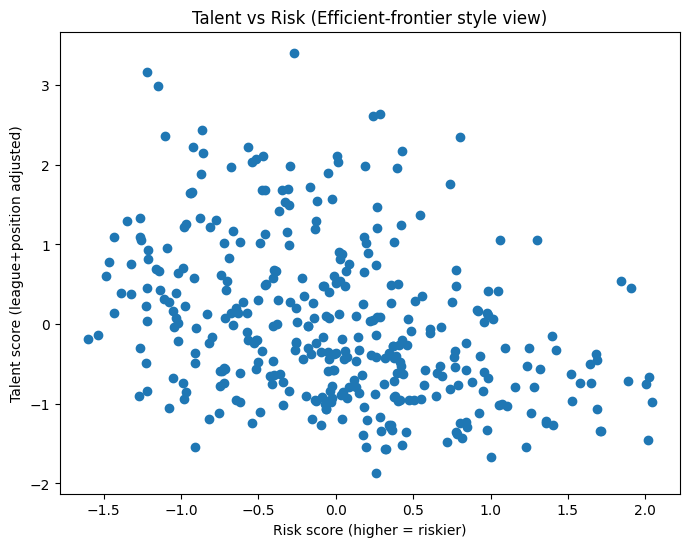

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df["risk_score"], df["talent_score"])
plt.xlabel("Risk score (higher = riskier)")
plt.ylabel("Talent score (league+position adjusted)")
plt.title("Talent vs Risk (Efficient-frontier style view)")
plt.show()

## 8. Conclusions

### Key results

- **Risk-adjusted framework**: We operationalized a club-tunable metric:
  - \(\mathrm{Value}(\lambda) = \mathrm{Talent} - \lambda \cdot \mathrm{Risk}\)
- **Ranking sensitivity**: The rankings are **moderately sensitive** to risk appetite (Spearman ρ printed above).
- **Shortlist turnover**: Moving from **λ=0 → λ=1** changes the Top-10 composition (printed above), demonstrating that risk preference materially affects marginal elite decisions.
- **Boom/bust profiles**: We identified players with the largest **rank drop** when introducing risk aversion, which corresponds to development bets (high uncertainty)

### Practical guidance for recruitment

- Use **λ≈0** for aggressive strategies (upside, development, higher variance).
- Use **λ≈0.5** as a balanced baseline for most clubs.
- Use **λ≈1.0** when prioritizing stability, immediate contribution, and lower variance.

### Deliverable for Notebook 04

The output of this notebook is a **decision-ready universe** with:
- `talent_score`
- `risk_score`
- `value_lambda_*`

This will feed the **budget-constrained shortlist optimisation** in Notebook 04.

---

## Appendix — Export (optional)

If you want to persist these outputs back to DuckDB for downstream notebooks:


In [9]:
# Optional: persist back to DuckDB for Notebook 04
OUT_TABLE = "risk_adjusted_universe_v1"

with duckdb.connect(str(DB_PATH)) as con:
    con.register("df_out", df)
    con.execute(f"CREATE OR REPLACE TABLE {OUT_TABLE} AS SELECT * FROM df_out")

print("Saved table:", OUT_TABLE)

Saved table: risk_adjusted_universe_v1
